<a href="https://colab.research.google.com/github/crispu93/GAP_images/blob/main/A_Deep_Learning_Framework_for_Graph_Partitioning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A Deep Learning Framework for Graph Partitioning

# Introduction

- Graph partitioning is an important optimization problem with numerous applications in domains spanning computer vision, biology, social networks, transportation networks, device placement and more. 
- The objective is to find balanced partitions while minimizing the number of edge cut.
- This problem is NP-complete, which is formulated as adiscrete optimization problem, and solutions are generally derived using heuristics and approximationalgorithms

## Basics of Graphs





Let $G=(V,E)$ be an undirected graph, where $V=\{v_1, v_2, ... , v_n\}$ is the non-empty set of nodes (or vertices) and $E$ is the set of edges, composed by pairs of the form $(v_i, v_j)$, where $v_i, v_j \in V$. 

We denote the **adjacency matrix** of the graph $G$ by the matrix $A = [a_{ij}]_{n\times n}$ where
$$
a_{ij} = \begin{cases} 
      1 & \text{ if } (v_i, v_j)\in E\\
      0 & \text{ otherwise }
   \end{cases}
   $$

and the **degree matrix** $D = [d_{ij}]_{n\times n}$ where
$$
d_{ij} = \begin{cases} 
      deg(v_i) & \text{ if } i = j\\
      0 & \text{ otherwise }
   \end{cases}
   $$

## The Graph Patitioning Problem

Given a graph $G$ and an integer $k$ the goal is to find a partition of $V$ into $k$ subsets $P_1, P_2, ... , P_k$, that is 
- $P_i\cap P_j = \emptyset \ \ \ $  for $i\neq j$, where $i,j\in\{1,2,...,k\}$
- $\cup_{i=1}^k P_k = V$

<!-- In the balanced graph partitioning problem, we also require the size of each component $P_i$ is equal to $\frac{n}{k}$. This is a more restricted problem so we relax it by setting up the restriction
$$
\max_i \vert P_i \vert \leq (1+\epsilon)\frac{n}{k}
$$ -->
In the balanced graph partitioning problem, we also require each partition $P_i$ is balanced with respect to some measure.

One way to get this, is to minimize the normalized cut ($\textbf{Ncut}$) which is based on graph conductance where the cost of a cut is computed as a fraction of the total edge connections to all nodes.

$$
\textbf{Ncut}(P_1, P_2, ..., P_k) = \sum_{i=1}^k \frac{\textbf{cut}(P_i, \overline{P_i})}{\textbf{vol}(P_i)}
$$

Where $\textbf{vol}(P_i) = \sum_{v_j\in P_i}deg(v_j)$

![cut of a graph](https://user-images.githubusercontent.com/1902679/34037816-738cf4ba-e18a-11e7-9343-7c27209b27e6.png)

# Generalizable Approximate Partitioning

One way to minimize the normalized cut is based on the eigenvectors of the graph Laplacian. In the work of Nazi et. al. it is introduced the *Generalizable Approximate Partitioning framework*(GAP).

As shown in the image below, GAP has two main components:
1. Graph embedding module
2. Graph partitioning module

The GAP model ingests a graph definition, generates a node embeddings that leverage local graph structure, and projects each embedding into logits(number between 0 and 1) that define a probability distribution to minimize the expected normalized cut.



![gap framework](https://raw.githubusercontent.com/crispu93/GAP_images/main/GAP.png)

The purpose of the graph embedding module is to learn node embeddings using the graph structure and node features. In this work we use Graph Convolutional Netwroks (GCN) to learn representations accross a variety of graphs, which helps with generalization.

The second module in the GAP framework is responsible for partitioning the graph taking in node embeddings and generating the probability that each node belongs to partitions $P_1, P_2, ..., P_k$.
This module is a fully connected layer followed by softmax, trained to minimize GAP loss function

## GAP loss function

GAP returns $Y\in \mathbb R^{n\times k}$ where $Y_{ij}$ represents the probability that node $v_i$ belongs to partition $P_j$.

$$
\mathbb{E}[\textbf{cut}(P_l, \overline{P_l})] = \sum_{\substack{v_i\in P_l \\ v_j\in \mathcal{N}(v_i)}}\sum_{z=1}^k Y_{iz}(1-Y_{jz})
$$

$$
\mathbb{E}[\textbf{cut}(P_l, \overline{P_l})] = \sum_{\text{reduce-sum}} Y_{:,l}(1-Y_{:,l})^T\odot A
$$

![expectation](https://raw.githubusercontent.com/crispu93/GAP_images/main/expectation.png)




On the other hand, we have $\textbf{vol}(P_i) = \sum_{v_j\in P_i}deg(v_j)$.

Let $\hat{D}$ be a column vector of size $n$ where $\hat{D}_i$ es the degree of the node $v_i\in V$. Given $Y$ we can calculate $\mathbb{E}[\textbf{Vol}(P_l)]$ as follows, where $\Gamma$ is a vector in $\mathbb R^k$.

$$\Gamma = Y^T\hat{D}, \ \ \text{where} \ \ \ \mathbb{E}[\textbf{Vol}(P_l)]=\Gamma_l$$

From the two values calculated for $\mathbb{E}[\textbf{cut}(P_l, \overline{P_l})]$ and $\mathbb{E}[\textbf{Vol}(P_l)]$ we can compute the expected value of the normalized cut as follows


$$
  \mathcal{L} = \mathbb{E}[\textbf{Ncut}(P_1,P_2,...,P_k)] = \sum_{\text{reduce-sum}} (Y\oslash \Gamma)(1-Y)^T\odot A
$$


## Convolutional Networks and message passing

A basic GCN layer is defined with the following propagation rule
$$
H^{(k)} = \sigma\left( \tilde{A}H^{(k-1)} W^{(k)}\right)
$$
Where $\tilde{A} = (D+I)^{-\frac{1}{2}}(A+I)(D+I)^{-\frac{1}{2}}$ is a normalized variant of the adjacency matrix with self loops and $W^{(k)}$ is a learnable parameter matrix. 


### Basics of Graph Convolutional Networks (GCN)

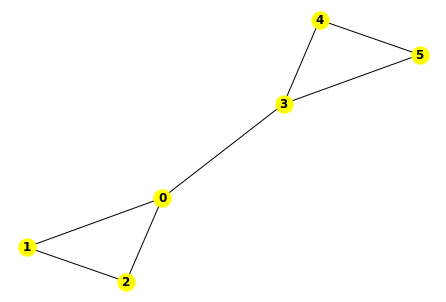

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

# Initalize a graph with n nodes with node features the name of the corresponding node
G = nx.Graph(name = 'G')
n = 6
for i in range(n):
  G.add_node(i, name = i)

edges = [(0, 1), (0, 2), (0, 3), (1, 2), (3, 4), (3, 5), (4, 5)]
G.add_edges_from(edges)

nx.draw(G, with_labels = True, node_color = 'yellow', font_weight = 'bold')
plt.show()

### Different convolutional filters

In [ ]:
# Compute the adjacency matrix and node features matrix
A = np.array(nx.attr_matrix(G, node_attr='name')[0])
X = np.array(nx.attr_matrix(G, node_attr='name')[1])
X = np.expand_dims(X, axis = 1)
AX = np.dot(A,X)

print('\n Adjacency Matrix (A):\n', A)
print('\n Node Features Matrix (X):\n', X)
print('\n AX:\n', AX)




 Adjacency Matrix (A):
 [[0. 1. 1. 1. 0. 0.]
 [1. 0. 1. 0. 0. 0.]
 [1. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 1. 1.]
 [0. 0. 0. 1. 0. 1.]
 [0. 0. 0. 1. 1. 0.]]

 Node Features Matrix (X):
 [[0]
 [1]
 [2]
 [3]
 [4]
 [5]]

 AX:
 [[6.]
 [2.]
 [1.]
 [9.]
 [8.]
 [7.]]


In [ ]:
G_self_loops = G.copy()
self_loops_list = []
for i in range(n):
  self_loops_list.append((i,i))

G_self_loops.add_edges_from(self_loops_list)
A_self_loops = np.array(nx.attr_matrix(G_self_loops, node_attr='name')[0])

#Compute the degree matrix of added self-loops G
D = G_self_loops.degree();

AX = np.dot(A_self_loops, X)
print('Adjacency Matrix of added self-loops G :\n', A_self_loops)
print('\n AX:\n', AX)

Adjacency Matrix of added self-loops G :
 [[1. 1. 1. 1. 0. 0.]
 [1. 1. 1. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0.]
 [1. 0. 0. 1. 1. 1.]
 [0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 1. 1. 1.]]

 AX:
 [[ 6.]
 [ 3.]
 [ 3.]
 [12.]
 [12.]
 [12.]]


### Normalizing term
$$\tilde{A} = A$$
Well connected nodes will have values associated with them that are larger
The deeper the network, the larger the values will be

$$\tilde{A} = D^{-1}A$$
You don't consider the connectivity of your neighbours. 

$$\tilde{A} = D^{-1}AD^{-1}$$
The deeper the network the smaller the values will become until reaching 0. The largest eigenvalue will be less than 1

$$\tilde{A} = D^{-\frac{1}{2}}AD^{-\frac{1}{2}}$$
It takes into account both your number of neighbours and their own number of neighbours.

All values will be in a similar range and independent of the number of layers

Similar to $D^{-1}A$ meaning they have the same eigenvalues (the largest being 1)

In [ ]:
from scipy.linalg import fractional_matrix_power

# Allow reproducibility
#np.random.seed(77777)

# Initialize weights
n_h = 4   # Number of neurons in the hidden layer
n_o = 2   # Number of neurons in the output layer
W0 = np.random.randn(X.shape[1], n_h)*0.1
W1 = np.random.randn(n_h,n_o)*0.1

# Use ReLu as activation function
def relu(x):
  return np.maximum(0,x)

# Define GCN layer
def gcn(A, H, W):
  I = np.identity(A.shape[0])
  A_hat = A + I   # Add self-loops
  D = np.diag(np.sum(A_hat, axis=0))  # Degre matrix with self loops
  D_half_norm = fractional_matrix_power(D, -0.5)
  aux = D_half_norm.dot(A_hat).dot(D_half_norm).dot(H).dot(W)
  return relu(aux)

# Do forward propagation
H1 = gcn(A,X,W0)
H2 = gcn(A,H1,W1)
print('Features Representation from GCN output:\n', H2)

Features Representation from GCN output:
 [[0.0124102  0.        ]
 [0.00773377 0.        ]
 [0.00773377 0.        ]
 [0.02370333 0.        ]
 [0.0241864  0.        ]
 [0.0241864  0.        ]]


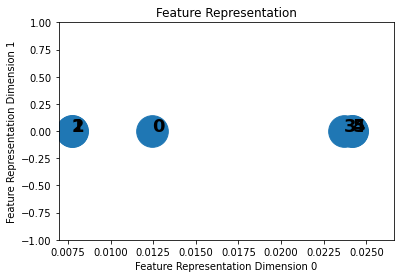

In [ ]:
def plot_features(H2):
    #Plot the features representation
    x = H2[:,0]
    y = H2[:,1]

    size = 1000

    plt.scatter(x,y,size)
    plt.xlim([np.min(x)*0.9, np.max(x)*1.1])
    plt.ylim([-1, 1])
    plt.xlabel('Feature Representation Dimension 0')
    plt.ylabel('Feature Representation Dimension 1')
    plt.title('Feature Representation')

    for i,row in enumerate(H2):
        str = "{}".format(i)
        plt.annotate(str, (row[0],row[1]),fontsize=18, fontweight='bold')

    plt.show()


plot_features(H2)

## Over-smoothing as convolutional filter

The intuitive idea of over-smoothing is that after too many rounds of message passing, the embeddings for all nodes begin to look identical and are relative uninformative. 

The key instuition is that stacking multiple rounds of message passing in a basic GNN is analogous to applying a low-pass convolutional filter, wich produces a smoothed version of the input signal of the graph.

Considering the simplification of a basic GNN with the following update rule:
$$
H^{(k)} = A_{sym}H^{(k-1)} W^{(k)}
$$

For mathematical simplicity and numerical stability we consider $A_{sym}$ which is defined as $A_{sym} = D^{-\frac{1}{2}}AD^{-\frac{1}{2}}$.

After $K$ rounds, we eill end up with a representation that depends on the $K$th power of the adjacency matrix:
$$
H^{(K)} = A_{sym}^KX W
$$
where $W$ is some linear operator and $X$ is the matrix of input node features.

We can use a large enough value of $K$ such that we have reached a fixed point of the following recurrence:
$$
A_{sym}H^{(K)} = H^{(K)}
$$

since the dominant eigenvalue of $A_{sym}$ is equal to one.

It will happen that at this point, all node features will have converged to be completely defined by the dominant eigenvector of $A_{sym}$, and more generally higher powers of $A_{sym}$ will emphasize the largest eigenvalues of this matrix.

We know that the largest eigenvalues of $A_{sym}$ correspond to the smallest eigenvalues of its counterpart, the symmetric normalized laplacian $L_{sym} = I - A_{sym}$.

Together, these facts imply that multiplying a signal by high powers of $A_{sym}$ corresponds to a convolutional filter based on the lowest eigenvalues (or frequencies) of $L_{sym}$, i.e., it produces a low pass filter.

Thus, stacking many rounds of message passing leads to convolutional filters that are low-pass, and in the worst case, these filters simply converge all the node representations to constant values within conected components of the graph (the zero-frequency of the Laplacian)


# References
[1] Nazi, A., Hang, W. et al (2019) A Deep Learning Framework for Graph Partitioning

[2] Hamilton, William L. Graph Representation Learning Synthesis Lectures on Artificial Intelligence and Machine Learning
